In [13]:
import os
import sys
import cv2
import numpy as np
import copy
import matplotlib.pyplot as plt
import torch
from torchvision import transforms
from PIL import Image


In [14]:
sys.path.append('..')
from a.task_2a import detect_ArUco_details, mark_ArUco_image

In [15]:
img = cv2.imread('sample.png')
orgimg = copy.deepcopy(img)
ArUco_details_dict, ArUco_corners = detect_ArUco_details(img)

img = mark_ArUco_image(img, ArUco_details_dict, ArUco_corners) 
cv2.imshow("Marked Image",img)
cv2.waitKey(0)
cv2.destroyAllWindows()

Bottom Left Event : 2 C(x-75), 2 C(y+ 75)
Top Left Event : 22 C(y+20), 15 C(y-20)
Mid Left Event : 5 C(x-100), 5 C(y+60)
Top Right Event : 54 C(x+50), 39 C(x-50)
Bottom Right Event : 53 C, 0 C(y+60)

In [16]:
# print(ArUco_corners[55])
marking_img = np.copy(orgimg)
centers = copy.deepcopy(ArUco_details_dict)
corners = copy.deepcopy(ArUco_corners)
events = [
    [corners[2][0], corners[2][3]], 
    [corners[53][1], corners[0][3]],
    [corners[54][1], corners[39][3]],     
    [centers[5][0], corners[5][3]], 
    [corners[22][3], centers[15][0]]   
]

changes = (
    (({0: -72, 1: 9}), ({1: 50, 0: -12 })),
    (({0: 30, 1: 10}), ({1: 50, 0: -20})), 
    (({0: 80, 1: 8}), ({0: -118, 1: -18})), 
    (({0: -135, 1: 3}), ({1: 51, 0: -68})), 
    (({1: 45, 0: 33}), ({1: -57, 0: -30})),    
)
for event in range(5):
    for corner in range(2):
        for axe in changes[event][corner]:
            events[event][corner][axe] += changes[event][corner][axe]

i=0
eventlist=[]
for tl, br in events:
    cv2.rectangle(marking_img, tl, br, (0, 255, 0), 2)
    roi = orgimg[tl[1]:br[1], tl[0]:br[0]]
    eventlist.append(roi)
    i+=1

cv2.imshow("Original Image", marking_img)

cv2.waitKey(0)
cv2.destroyAllWindows()


In [17]:
from matplotlib import cm

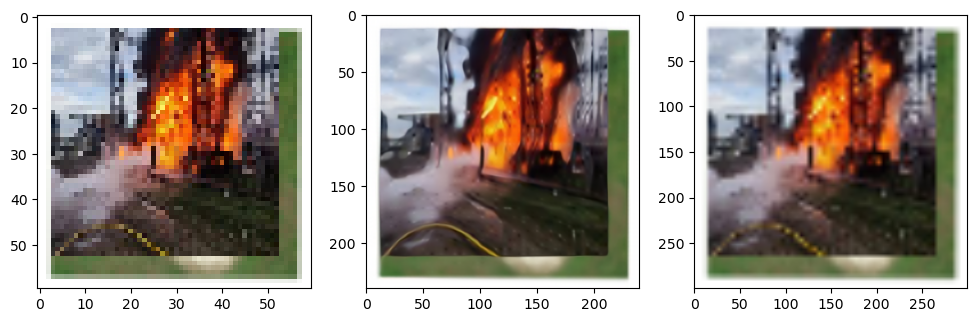

fire


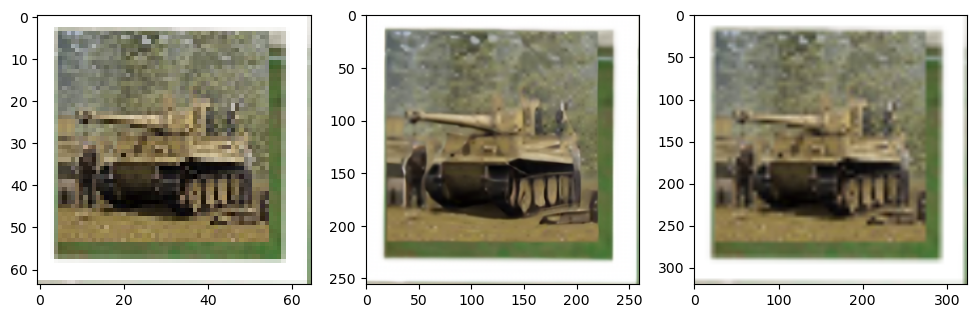

militaryvehicles


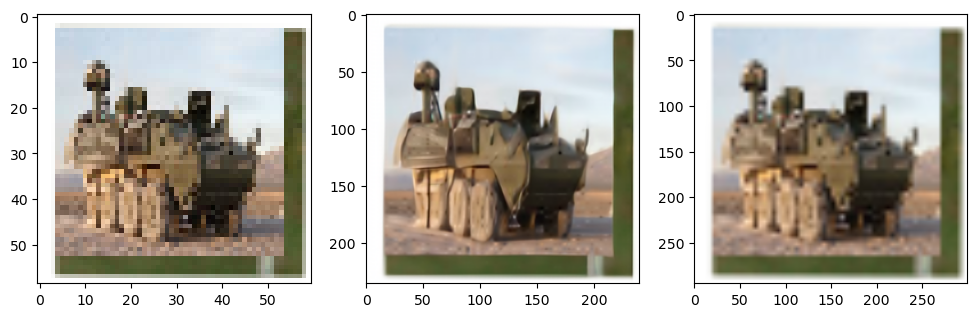

militaryvehicles


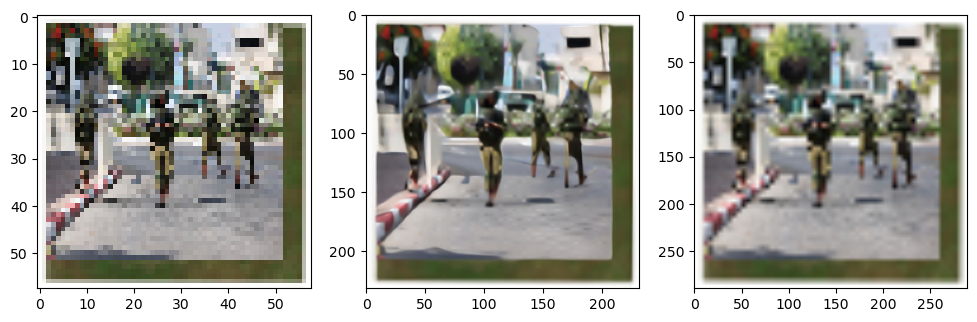

destroyedbuilding


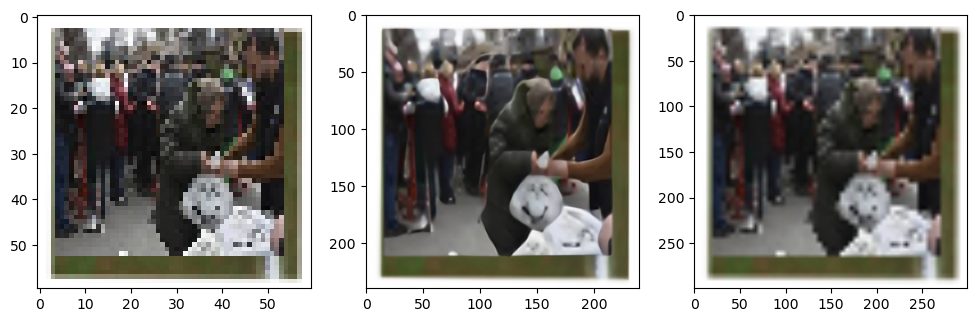

humanitarianaid


In [19]:
device = "cuda" if torch.cuda.is_available() else "cpu"
model = torch.load("../b/model.tf")
model.eval()
# image = np.expand_dims(image_resized, axis=0)
image_transform = transforms.Compose([
        transforms.ToTensor(),
        transforms.Resize((224, 224), antialias=False),
        
        transforms.Normalize(mean=[0.485, 0.456, 0.406], std=[0.229, 0.224, 0.225]),
    ])
for image in eventlist:
    # plt.imshow(image[:,:,::-1])
    # plt.show()

    # image = cv2.resize(image, (224, 224))


    sr = cv2.dnn_superres.DnnSuperResImpl_create()
 
    path = "EDSR_x4.pb"
    
    sr.readModel(path)
    
    sr.setModel("edsr",4)
    
    result = sr.upsample(image)
    resized = cv2.resize(image,dsize=None,fx=5,fy=5)
    
    plt.figure(figsize=(12,8))
    plt.subplot(1,3,1)
    # Original image
    plt.imshow(image[:,:,::-1])
    plt.subplot(1,3,2)
    # SR upscaled
    plt.imshow(result[:,:,::-1])
    plt.subplot(1,3,3)
    # OpenCV upscaled
    plt.imshow(resized[:,:,::-1])
    plt.show()
    
    # OpenCV upscaled
    with torch.inference_mode():
        # 6. Transform and add an extra dimension to image (model requires samples in [batch_size, color_channels, height, width])
        transformed_image = image_transform(result).unsqueeze(dim=0)
        # 7. Make a prediction on image with an extra dimension and send it to the target device
        target_image_pred = model(transformed_image.to(device))

    # 8. Convert logits -> prediction probabilities (using torch.softmax() for multi-class classification)
    target_image_pred_probs = torch.softmax(target_image_pred, dim=1)

    # 9. Convert prediction probabilities -> prediction labels
    pred = torch.argmax(target_image_pred_probs, dim=1)

    # pred = model.predict(image)
    class_names = ['combat', 'destroyedbuilding', 'fire', 'humanitarianaid', 'militaryvehicles']
    event = class_names[pred]
    print(event)